In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]

In [2]:
from majordome.utilities import Capturing
import casadi as cs
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Specific mass [kg/m³].
rho = 150.0

# Specific heat in mass units [J/(kg.K)].
cpm = 700.0

# Mass flow rate [kg/s].
mdot = 0.096

In [4]:
def enthalpy(T, h0=0.0):
    """ Transported material enthalpy.
    
    Parameters
    ----------
    T : float
        Temperature [K].
    h0 : float
        Enthalpy at 298.15 K [J/kg].
    """
    return cpm * T + h0

In [5]:
def kiln_bed_area(R, h):
    """ Compute bed cross-section in rotary kiln.
    
    Parameters
    ----------
    R : float
        Reactor radius [m].
    h : float
        Bed height [m].

    Return
    ------
    float
        Reactor cross section [m²].
    """
    # Gap between bed and center [m].
    d = R - h

    # Semi-surface length of bed [m].
    b = np.sqrt(R**2 - d**2)

    # Semi-angle of bed [rad].
    phi = 2 * np.arcsin(b / R)

    # Area unde semi-angle [m²].
    Aphi = (phi / 2) * R

    # Area of triangle over bed [m²].
    Atri = d * (2 * b) / 2

    # Area of reactor bed cross-section [m²]
    Abed = Aphi - Atri

    return Abed, 2 * b

In [13]:
# Reactor length [m].
L = 11.6

# Length discretization [m].
dx = 0.01

# Initial temperature [K].
T0 = 300.0

# Global heat transfer coefficient [W/(m².K)].
U = 50.0

# Constant reactor cross-section [m²] and width [m].
A, l = kiln_bed_area(R=0.6, h=0.18)

# Center points of cells in FV.
xc = np.arange(dx/2, L-0.49*dx, dx)

# Number of cells over axis.
nx = xc.shape[0]

# Area of individual bed sections [m²].
# NOTE: first is used in B.C. computation.
Ax = A * np.ones(nx + 1)

# Advection rate [m/s]
ux = mdot / (rho * Ax)

# Environment temperature [K].
Ti = 700.0 * np.ones(nx)

# Area of bed-gas interfaces [m²].
As = l * dx * np.ones(nx)

# Volume of reactor slice [m³].
Vs = Ax[1:] * dx

# Enthalpy at cells [J/kg].
# NOTE: first is used in B.C. computation.
Tx = cs.SX.sym("Tx", nx + 1)

In [18]:
hx = enthalpy(Tx)

lhs = rho * (ux[:-1] * hx[:-1] - ux[1:] * hx[1:])
rhs = U * As * (Tx[1:] - Ti) #/ Vs

In [19]:
# Constrain inlet temperature.
g = [Tx[0] - T0]

# Constrain cell equations.
for k in range(0, nx):
    g.append(lhs[k] - rhs[k])

# Create non-linear problem.
nlp = {
    "x": Tx,
    "f": 1, 
    "g": cs.vertcat(*g)
}

# Create solver and check interface.
solver = cs.nlpsol("solver", "ipopt", nlp)
solver

Function(solver:(x0[1161],p[],lbx[1161],ubx[1161],lbg[1161],ubg[1161],lam_x0[1161],lam_g0[1161])->(x[1161],f,g[1161],lam_x[1161],lam_g[1161],lam_p[]) IpoptInterface)

In [20]:
with Capturing() as out:
    optim = solver(x0=np.ones(nx+1), lbg=0.0, ubg=0.0)

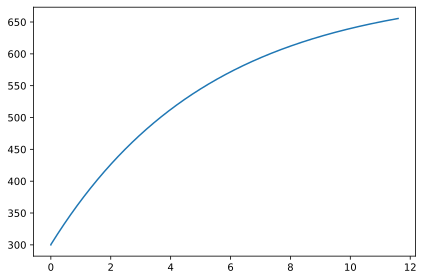

In [21]:
T = optim["x"].full().ravel()

plt.plot([0, *xc], T)
plt.tight_layout()

In [28]:
sum(optim["g"].full()), max(optim["g"].full())

(array([2.00645189e-09]), array([5.02424768e-11]))